In [ ]:
# MIT License
#
#@title Copyright (c) 2021 CCAI Community Authors { display-mode: "form" }
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

In [ ]:
#作業ディレクトリの設定
import os
os.chdir("..")
os.chdir("..")
os.getcwd()

## 1. 学習済みモデル（力場）のダウンロード

学習済みのモデルを右記リンクからダウンロードします。[here](https://github.com/Open-Catalyst-Project/ocp/blob/master/MODELS.md)学習済みのモデルはASEのCalculatorクラスとして使用できます。

※今回はリンク先から該当ファイルを直接ダウンロードしocpフォルダに格納しました。なお当検討ではoc20+oc22モデルを使用しましたが、取り扱うのは純金属でしたのでoc20でも構いません（学習データは重複しているので、挙動はほぼ類似するものと推察されます）。
、

In [ ]:
from ocpmodels.common.relaxation.ase_utils import OCPCalculator
import ase.io
from ase.optimize import LBFGS
from ase.build import fcc100, fcc111, add_adsorbate, molecule
import os
from ase.constraints import FixAtoms
import numpy as np
from ase.io import extxyz
from ase.data import atomic_numbers

import ase
from ase import Atoms, units, Atom
from ase.units import Bohr,Rydberg,kJ,kB,fs,Hartree,mol,kcal
from ase.io import read, write
from ase.build import surface, molecule, add_adsorbate
from ase.constraints import FixAtoms, FixedPlane, FixBondLength, ExpCellFilter
from ase.neb import NEB
from ase.vibrations import Vibrations
from ase.thermochemistry import IdealGasThermo
from ase.visualize import view
from ase.build.rotate import minimize_rotation_and_translation
from ase.optimize import BFGS, LBFGS, FIRE
from ase.md import MDLogger
from ase.io import read, write, Trajectory
from ase.build import sort
import pandas as pd
from ase.build import bulk

#モデルの置き場所（絶対パスで指定）
checkpoint_path = "C:/Users/****/ocp/gnoc_oc22_oc20_all_s2ef.pt"
config_yml_path = r"C:\Users\****\ocp\configs\oc22\s2ef\gemnet-oc\gemnet_oc_oc20_oc22.yml"

#Define the calculator
calc = OCPCalculator(config_yml=config_yml_path, checkpoint=checkpoint_path, cpu = False)

## 2. 候補構造の読込と格子定数の最適化

In [ ]:
#格子定数を任意の範囲で振ってエネルギー最適点を求める関数（返り値は最適化済みのatoms）
def opt_bulk(atom, min_a, max_a):
    a = [] #格子定数の倍数
    a = pd.DataFrame(np.empty((0, 2)), columns = ["energy", "a"])
    for i in np.linspace(min_a, max_a):
        metal = atom.copy()
        ref = metal.cell
        metal.cell = i * ref
        metal.set_tags(np.ones(len(metal)))

        metal.calc = calc

        e = (metal.get_potential_energy())
        a = a.append({"energy": e,
                      "a": i}, ignore_index = True)

        del metal, ref
    
    opt_a = a["a"][a['energy'].idxmin()]
    
    bulk_opt = atom.copy()
    ref = bulk_opt.cell
    bulk_opt.cell = opt_a * ref
    return bulk_opt

In [ ]:
def create_folder(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print("フォルダが作成されました。")
    else:
        print("指定されたパスのフォルダは既に存在します。")

In [ ]:
import re
import math

def simplify_chemical_formula(formula):
    elements = {}
    element_pattern = r"([A-Z][a-z]?)(\d*)"

    matches = re.findall(element_pattern, formula)
    for match in matches:
        element_name = match[0]
        element_count = match[1] if match[1] != "" else "1"
        element_count = int(element_count)
        if element_name in elements:
            elements[element_name] += element_count
        else:
            elements[element_name] = element_count

    # 最小公約数を求める
    gcd = math.gcd(*elements.values())

    simplified_formula = ""
    for element, count in elements.items():
        simplified_count = count // gcd
        if simplified_count == 1:
            simplified_formula += element
        else:
            simplified_formula += element + str(simplified_count)

    return simplified_formula



In [ ]:
from ase import Atoms
from ase.build import surface


def makesurface(
    atoms: Atoms, miller_indices=(1, 1, 1), layers=4, rep=[4, 4, 1]
) -> Atoms:
    s1 = surface(atoms, miller_indices, layers)
    s1.center(vacuum=10.0, axis=2)
    s1 = s1.repeat(rep)
    s1.set_positions(s1.get_positions() - [0, 0, min(s1.get_positions()[:, 2])])
    s1.pbc = True
    return s1

In [ ]:
#表面エネルギーを計算し構造を格納する
def surface_energy(bulk, miller, cif_output_path):
    #名前の定義
    cif_name = bulk.get_chemical_formula()
    cif_name = simplify_chemical_formula(cif_name)
        
    #最適化済みのバルク構造を読込
    bulk.calc = calc
    bulk.set_tags(np.ones(len(bulk)))

    E_bulk = bulk.get_potential_energy()
    #スラブ構造の切り出し
    slab = makesurface(bulk, miller_indices = miller, layers = 2, rep = [1, 1, 1])
    slab.calc = calc
    slab.set_tags(np.ones(len(slab)))
    
    slab.positions += [0, 0, 3]
    slab.wrap()

    opt = LBFGS(slab)
    opt.run(fmax=0.05, steps = 1000)
    slab_file_path = cif_output_path + cif_name + "/slab_opt/" + cif_name + str(miller).replace(", ","_") + ".cif"
    ase.io.write(slab_file_path, slab, format='cif')

    E_slab = slab.get_potential_energy()
    
    cx, cy, cz = slab.cell
    A = np.linalg.norm(np.cross(cx, cy))

    E_surface = (E_slab - E_bulk * len(slab) / len(bulk)) / (2 * A)
    
    return E_surface    

In [ ]:
def find_minimum_index(lst):
    min_value = min(lst)
    min_index = lst.index(min_value)
    return min_index

Materials Projectから引用した結晶構造に対し、格子定数を最適化します。Input_cifsフォルダに格納されたCo.cifを読込んで、これを最適化しましょう。

In [ ]:
path = "./20230801_CO_dissociation_on_metal/"

In [ ]:
import glob
#input_cifのパス取得
cif_path = path + "Input_cifs/"
cif_files = glob.glob(cif_path + '/*.cif')  # CIFファイルのパスを取得
print(cif_files)

In [ ]:
import glob
#input_cifのパス取得
cif_path = path + "Input_cifs/"
cif_files = glob.glob(cif_path + '/*.cif')  # CIFファイルのパスを取得

#Output_path
cif_output_path = path + "Outputs/support/"

#ファイル読込と構造最適化
cif_list = []
for file_path in cif_files:
    #ファイルの読込
    cif_data = read(file_path)*(4,2,4)
    cif_name = cif_data.get_chemical_formula()
    cif_name = simplify_chemical_formula(cif_name)

    create_folder(cif_output_path + cif_name + "/opt/")
    create_folder(cif_output_path + cif_name + "/slab_opt/")
    
    #格子定数の最適化
    cif_opt = opt_bulk(cif_data, 0.95, 1.05)
    cif_file_path = cif_output_path + cif_name + "/opt/" + cif_name + ".cif"
    ase.io.write(cif_file_path, cif_opt, format='cif')
    
    #各表面の最適化とエネルギー算出、構造格納
    surface_energy_list = []
    miller_list = [(1,1,1)]#(1,1,1)以外を追加してもOK
    for miller in miller_list:
        print(miller)
        cif_opt = read(cif_file_path)
        print(cif_opt)
        surface_energy_a = surface_energy(cif_opt, miller, cif_output_path)
        
        print(surface_energy_a)
        surface_energy_list.append({"surface": miller,
                                    "energy": surface_energy_a})
        df_surface_energy = pd.DataFrame(surface_energy_list)
        df_surface_energy.to_csv(cif_output_path + cif_name + "/surface_energy.csv")
    
    

In [ ]:
view(read("./20230801_CO_dissociation_on_metal/Outputs/support/Co/slab_opt/Co(1_1_1).cif"))

Co(111)面が作成されました。
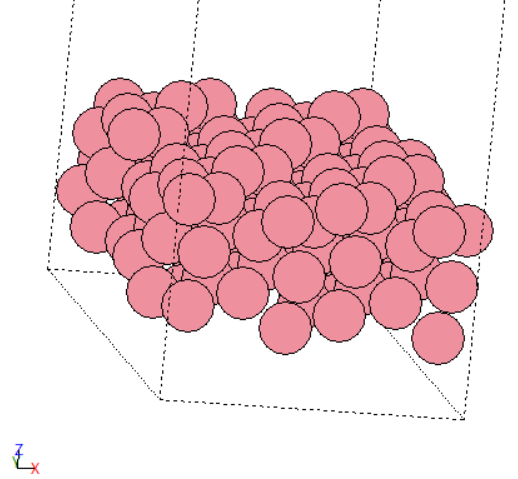

## 3. 吸着構造の作成と網羅的最適化

ここからは作成した構造をもとに、反応物および生成物の吸着構造を作成します。今回想定する反応はCO -> C + Oですので、吸着対象はこれら3つとなります。ここで、各吸着物については、Co(111)面のどこに吸着させることが好ましいか、ということを我々は知りません。従って、複数の吸着点をそれぞれの分子について試して、最もエネルギー的に安定な点を採用する、という形式をとります。

In [ ]:
from ase import Atoms
from ase.build import fcc111

# レイヤー数を測定する関数
def measure_layer_number(slab, threshold):
    # z座標を基準に昇順にソート
    sorted_indices = sorted(range(len(slab)), key=lambda i: slab.positions[i, 2])

    # レイヤーの境界を検出
    layer_boundaries = [0]
    current_z = slab.positions[sorted_indices[0], 2]
    for i in sorted_indices:
        if abs(slab.positions[i, 2] - current_z) > threshold:
            layer_boundaries.append(i)
            current_z = slab.positions[i, 2]
    layer_boundaries.append(len(slab))

    # レイヤー数を計算
    layer_number = len(layer_boundaries) - 1

    return layer_number


In [ ]:
def Calculate_adsorption_energy(slab_path, mol, fmax, steps, mol_on_slab_path, num_1, num_2):
    energies = []
    #吸着構造最適化とエネルギーの計算
    adslab = read(slab_path)
    adslab_name = simplify_chemical_formula(adslab.get_chemical_formula())
    baisu = round(8/(len(adslab)/measure_layer_number(adslab, 1)))
    
    if len(adslab) <= 50:
        adslab = adslab * (baisu, baisu, 1)
    
    adsorbate = molecule(mol)
    
    adslab = adslab[np.argsort(adslab.positions[:, 2])]

    # tag all slab atoms below surface as 0, surface as 1
    tags = np.zeros(len(adslab))
    tags[round(len(adslab)*0.8):len(adslab)] = 1
    adslab.set_tags(tags)
    # Fixed atoms are prevented from moving during a structure relaxation. 
    # We fix all slab atoms beneath the surface. 
    cons= FixAtoms(indices=[atom.index for atom in adslab if (atom.tag == 0)])
    adslab.set_constraint(cons)
    adslab.center(vacuum=13.0, axis=2)
    adslab.set_pbc(True)
    # Set up the calculator
    adslab.set_calculator(calc)

    # calculate energy
    relaxed_energy = adslab.get_potential_energy()
        
    #calculate adsorption energy
    for i in range(1, num_1, 1):
        for j in range(1, num_2, 1):

            mol_on_slab = adslab.copy()
            mol_on_slab = mol_on_slab[np.argsort(mol_on_slab.positions[:, 2])]

            # height: height of molecule from slab surface
            # position: x,y position of molecule
            # The molecule position can be modified later, and thus rough value is ok here.
            add_adsorbate(mol_on_slab, adsorbate, height=1, position=(i, j))

            # tag all slab atoms below surface as 0, surface as 1
            tags = np.zeros(len(mol_on_slab))
            tags[round(len(adslab)*0.8) + len(adsorbate):len(mol_on_slab)] = 1
            mol_on_slab.set_tags(tags)
            # Fixed atoms are prevented from moving during a structure relaxation. 
            # We fix all slab atoms beneath the surface. 
            cons= FixAtoms(indices=[atom.index for atom in mol_on_slab if (atom.tag == 0)])
            mol_on_slab.set_constraint(cons)

            # Set up the calculator
            mol_on_slab.set_calculator(calc)
            # Define structure optimizer - LBFGS. Run for 100 steps, 
            # or if the max force on all atoms (fmax) is below 0 ev/A.
            # fmax is typically set to 0.01-0.05 eV/A, 
            # for this demo however we run for the full 100 steps.
            dyn = LBFGS(mol_on_slab)
            dyn.run(fmax=0.05, steps=1000)
            
            mol_on_slab_energy = mol_on_slab.get_potential_energy()
            
            filename = os.path.basename(slab_path).split(".")[0]
            mol_on_slab_file_path = mol_on_slab_path + filename + str(i) + str(j) + adsorbate.get_chemical_formula() + ".cif"
            ase.io.write(mol_on_slab_file_path, mol_on_slab, format='cif')
            
            #分子のエネルギー計算（これは関数化すべき）
            adsorbate_s = adsorbate.get_chemical_symbols()
            # For clarity, we define arbitrary gas reference energies here.
            # A more detailed discussion of these calculations can be found in the corresponding paper's SI. 
            gas_reference_energies = {'H': .3, 'O': .45, 'C': .35, 'N': .50}
            adsorbate_reference_energy = 0
            for ads in adsorbate_s:
                adsorbate_reference_energy += gas_reference_energies[ads]
            adsorption_energy = mol_on_slab_energy - relaxed_energy - adsorbate_reference_energy
            print(adsorption_energy)
            
            data = {"name": adslab_name, "i": i, "j": j, "mol": mol, "adsorption_energy": adsorption_energy}
            
            energies.append(data)
            
            del mol_on_slab
    
    return energies

In [ ]:
# 指定された条件のフォルダ内のCIFファイルを読み込む
cif_output_path = path + "Outputs/support/"

folder_list = [folder for folder in os.listdir(cif_output_path)]
folder_list


ここからが実際の吸着構造計算およびエネルギーの計算となります。

In [ ]:

mol_list = ["CO", "C", "O"]#吸着対象
Energies_sum = []

for folder in folder_list:
    for mol in mol_list:
        slab_path = cif_output_path + folder + "/slab_opt/"
        mol_on_slab_path = cif_output_path + folder + "/mol_on_slab_opt/"
        slab_path_cif = glob.glob(slab_path + '/*.cif')  # CIFファイルのパスを取得
        create_folder(mol_on_slab_path)
        
        for slab_file in slab_path_cif:
            Energies = Calculate_adsorption_energy(slab_file, mol, 0.05, 1000, mol_on_slab_path, 4, 3)#（1,1）から(3,2)までの6吸着点を計算
            Energies_sum.append(Energies)


計算結果を確認します（絶対値がやたら大きいのは私が原子の参照エネルギーを誤入力（oc20の値をそのまま使用）したためですので無視ください）。この中で最もエネルギーが低い値を採用します。

In [ ]:
#計算結果の確認
pd.DataFrame(Energies_sum[1])

In [ ]:
#構造の確認
view(read("./20230801_CO_dissociation_on_metal/Outputs/support/Co/mol_on_slab_opt/Co(1_1_1)11CO.cif"))

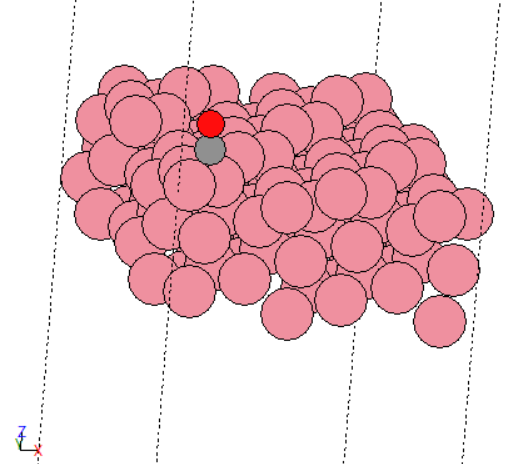

In [ ]:
#計算結果をcsvファイルに保存
min_E = pd.DataFrame(columns = ["name", "i", "j", "mol", "adsorption_energy"])

for i in range(len(Energies_sum)):
    data = pd.DataFrame(Energies_sum[i])
    # 吸着エネルギーが最小の行を抽出
#    min_energy_row = data.loc[data['adsorption_energy'].idxmin()]
#    print(min_energy_row)
    min_E = min_E.append(data)

min_E

In [ ]:
min_E.to_csv(path + "/Outputs/20230802_ads_energy_CO_decomposition.csv")

## 4. 表面元素の置換効果  
続いて、下記文献に記載のとおり、Co表面にVを添加した場合に吸着エネルギーがどうなるか、を見ていきましょう。
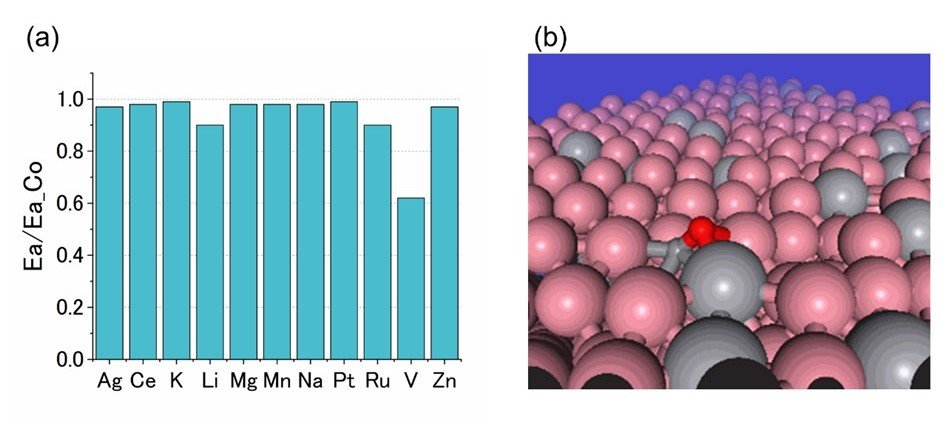

この効果を見るため、先ほど使用したCoの一部をVに置換していきます。具体的には下記の関数を使用します。

In [ ]:
#元のスラブに対し、最表面の原子を任意割合で任意の元素に置換し、最適化する関数
def slab_substitution(slab_path, fmax, steps, sub_atom_num, sub_ratio, slab_save_path):
    energies = []
    #吸着構造最適化とエネルギーの計算
    adslab = read(slab_path)
    adslab_name = simplify_chemical_formula(adslab.get_chemical_formula())
    baisu = round(8/(len(adslab)/measure_layer_number(adslab, 1)))
    
    if len(adslab) <= 50:
        adslab = adslab * (baisu, baisu, 1)
    
    adsorbate = molecule(mol)
    
    adslab = adslab[np.argsort(adslab.positions[:, 2])]
    
    #最表面の原子を指定した割合で置換
    numbers = adslab.get_atomic_numbers()
    index_list = list(range(round(len(adslab)*0.8), len(adslab)))
    replace_index = np.random.choice(index_list, size=round(len(index_list)*sub_ratio), replace=False)
    numbers[replace_index] = sub_atom_num
    adslab.set_atomic_numbers(numbers)

    # tag all slab atoms below surface as 0, surface as 1
    tags = np.zeros(len(adslab))
    tags[round(len(adslab)*0.8):len(adslab)] = 1
    adslab.set_tags(tags)
    # Fixed atoms are prevented from moving during a structure relaxation. 
    # We fix all slab atoms beneath the surface. 
    cons= FixAtoms(indices=[atom.index for atom in adslab if (atom.tag == 0)])
    adslab.set_constraint(cons)
    adslab.center(vacuum=13.0, axis=2)
    adslab.set_pbc(True)
    # Set up the calculator
    adslab.set_calculator(calc)
    dyn = LBFGS(adslab)
    dyn.run(fmax=0.05, steps=1000)
    filename = os.path.basename(slab_path).split(".")[0]

    adslab_name = simplify_chemical_formula(adslab.get_chemical_formula())
    ase.io.write(slab_save_path + adslab_name + filename + ".cif", adslab, format='cif')
    return adslab

In [ ]:
#元のスラブに対し、最表面の原子を任意割合で任意の元素に置換し、任意分子の吸着エネルギーを測定する関数
def Calculate_adsorption_energy_substitution(slab, mol, fmax, steps, mol_on_slab_path, num_1, num_2, slab_path):
    energies = []
    #吸着構造最適化とエネルギーの計算
    adslab = slab.copy()
    adslab_name = simplify_chemical_formula(adslab.get_chemical_formula())
    baisu = round(8/(len(adslab)/measure_layer_number(adslab, 1)))
    
    if len(adslab) <= 50:
        adslab = adslab * (baisu, baisu, 1)
    
    adsorbate = molecule(mol)
    
    adslab = adslab[np.argsort(adslab.positions[:, 2])]
    
    # tag all slab atoms below surface as 0, surface as 1
    tags = np.zeros(len(adslab))
    tags[round(len(adslab)*0.8):len(adslab)] = 1
    adslab.set_tags(tags)
    # Fixed atoms are prevented from moving during a structure relaxation. 
    # We fix all slab atoms beneath the surface. 
    cons= FixAtoms(indices=[atom.index for atom in adslab if (atom.tag == 0)])
    adslab.set_constraint(cons)
    adslab.center(vacuum=13.0, axis=2)
    adslab.set_pbc(True)
    # Set up the calculator
    adslab.set_calculator(calc)

    # calculate energy
    relaxed_energy = adslab.get_potential_energy()
        
    #calculate adsorption energy
    for i in range(1, num_1, 1):
        for j in range(1, num_2, 1):

            mol_on_slab = adslab.copy()
            mol_on_slab = mol_on_slab[np.argsort(mol_on_slab.positions[:, 2])]

            # height: height of molecule from slab surface
            # position: x,y position of molecule
            # The molecule position can be modified later, and thus rough value is ok here.
            add_adsorbate(mol_on_slab, adsorbate, height=1, position=(i, j))

            # tag all slab atoms below surface as 0, surface as 1
            tags = np.zeros(len(mol_on_slab))
            tags[round(len(adslab)*0.8) + len(adsorbate):len(mol_on_slab)] = 1
            mol_on_slab.set_tags(tags)
            # Fixed atoms are prevented from moving during a structure relaxation. 
            # We fix all slab atoms beneath the surface. 
            cons= FixAtoms(indices=[atom.index for atom in mol_on_slab if (atom.tag == 0)])
            mol_on_slab.set_constraint(cons)

            # Set up the calculator
            mol_on_slab.set_calculator(calc)
            # Define structure optimizer - LBFGS. Run for 100 steps, 
            # or if the max force on all atoms (fmax) is below 0 ev/A.
            # fmax is typically set to 0.01-0.05 eV/A, 
            # for this demo however we run for the full 100 steps.
            dyn = LBFGS(mol_on_slab)
            dyn.run(fmax=0.05, steps=1000)
            
            mol_on_slab_energy = mol_on_slab.get_potential_energy()
            
            filename = os.path.basename(slab_path).split(".")[0]
            mol_on_slab_file_path = mol_on_slab_path + adslab_name + filename + str(i) + str(j) + adsorbate.get_chemical_formula() + ".cif"
            ase.io.write(mol_on_slab_file_path, mol_on_slab, format='cif')
            
            #分子のエネルギー計算（これは関数化すべき）
            adsorbate_s = adsorbate.get_chemical_symbols()
            # For clarity, we define arbitrary gas reference energies here.
            # A more detailed discussion of these calculations can be found in the corresponding paper's SI. 
            gas_reference_energies = {'H': .3, 'O': .45, 'C': .35, 'N': .50}
            adsorbate_reference_energy = 0
            for ads in adsorbate_s:
                adsorbate_reference_energy += gas_reference_energies[ads]
            adsorption_energy = mol_on_slab_energy - relaxed_energy - adsorbate_reference_energy
            print(adsorption_energy)
            
            data = {"name": adslab_name, "i": i, "j": j, "mol": mol, "adsorption_energy": adsorption_energy}
            
            energies.append(data)
            
            del mol_on_slab
    
    return energies

上記の関数を用いて、元のCo表面を一部バナジウムで置換した構造に対し着目する分子の吸着構造を網羅的に作成します（計算内容はCoでやったのと同じ）。この効果がどう出るかは、もう一つのnotebookで確認してみましょう。

In [ ]:
mol_list = ["CO", "C", "O"]
Energies_sum_sub = []

for folder in folder_list:
    slab_path = cif_output_path + folder + "/slab_opt/"
    mol_on_slab_path = cif_output_path + folder + "/mol_on_slab_opt/"
    slab_path_cif = glob.glob(slab_path + '/*.cif')  # CIFファイルのパスを取得
    create_folder(mol_on_slab_path)

    for slab_file in slab_path_cif:
        adslab = slab_substitution(slab_file, 0.05, 1000, 23, 0.4, slab_path)
        
        for mol in mol_list:            
            Energies = Calculate_adsorption_energy_substitution(adslab, mol, 0.05, 1000, mol_on_slab_path, 4, 3, slab_file)
            Energies_sum_sub.append(Energies)


In [ ]:
min_E_sub = pd.DataFrame(columns = ["name", "i", "j", "mol", "adsorption_energy"])

for i in range(len(Energies_sum_sub)):
    data = pd.DataFrame(Energies_sum_sub[i])
    # 吸着エネルギーが最小の行を抽出
#    min_energy_row = data.loc[data['adsorption_energy'].idxmin()]
#    print(min_energy_row)
    min_E_sub = min_E_sub.append(data)


In [ ]:
min_E_sub.to_csv(path + "/Outputs/20230802_ads_energy_CO_decomposition_sub.csv")

In [ ]:
#構造の確認
view(read("./20230801_CO_dissociation_on_metal/Outputs/support/Co/mol_on_slab_opt/Co59V5Co(1_1_1)11CO.cif"))

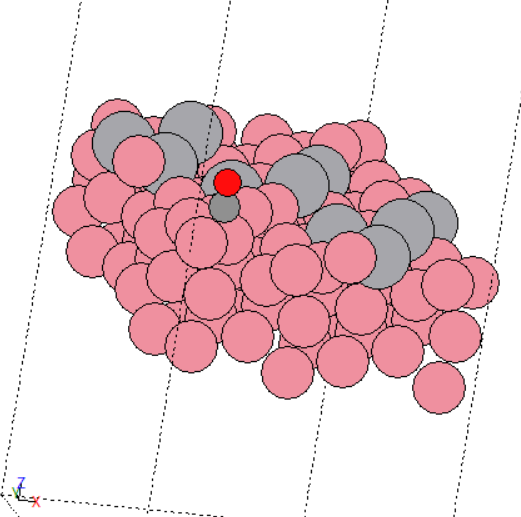